In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.cluster import hierarchy, vq

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', 150)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

## Lab 1 : Principal Component Analysis

In [145]:
df = pd.read_csv('Data/USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.8+ KB


In [146]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [147]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [148]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [149]:
pca = PCA(n_components=None)
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [150]:
pca_loadings = pd.DataFrame(pca.components_.T, 
                            index=df.columns,
                            columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_loadings

               PC1       PC2       PC3       PC4
Murder   -0.535899  0.418181 -0.341233  0.649228
Assault  -0.583184  0.187986 -0.268148 -0.743407
UrbanPop -0.278191 -0.872806 -0.378016  0.133878
Rape     -0.543432 -0.167319  0.817778  0.089024

In [151]:
df_plot = pd.concat([(X*pca_loadings.PC1).sum(axis=1),(X*pca_loadings.PC2).sum(axis=1)], axis=1, keys=['PC1', 'PC2'])
df_plot.head()

                 PC1       PC2
Alabama    -0.985566  1.133392
Alaska     -1.950138  1.073213
Arizona    -1.763164 -0.745957
Arkansas    0.141420  1.119797
California -2.523980 -1.542934

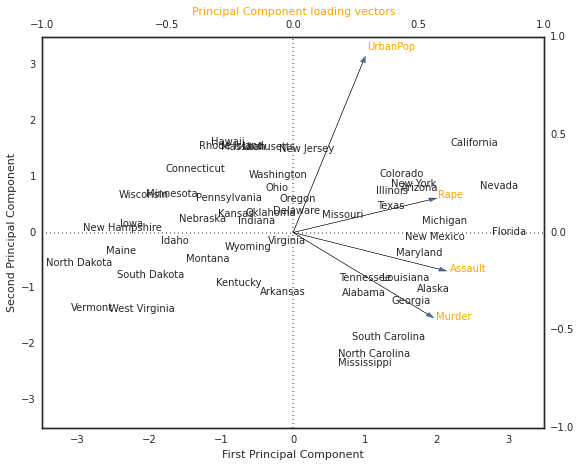

In [152]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['PC1', 'PC2']].index:
    ax2.annotate(i, (-pca_loadings.PC1.loc[i]*a, -pca_loadings.PC2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,-pca_loadings.PC1[0], -pca_loadings.PC2[0])
ax2.arrow(0,0,-pca_loadings.PC1[1], -pca_loadings.PC2[1])
ax2.arrow(0,0,-pca_loadings.PC1[2], -pca_loadings.PC2[2])
ax2.arrow(0,0,-pca_loadings.PC1[3], -pca_loadings.PC2[3])

In [153]:
np.sqrt(pca.explained_variance_)

array([ 1.57487827,  0.99486941,  0.59712912,  0.41644938])

In [154]:
pca.explained_variance_

array([ 2.48024158,  0.98976515,  0.35656318,  0.17343009])

In [155]:
pca.explained_variance_ratio_

array([ 0.62006039,  0.24744129,  0.0891408 ,  0.04335752])

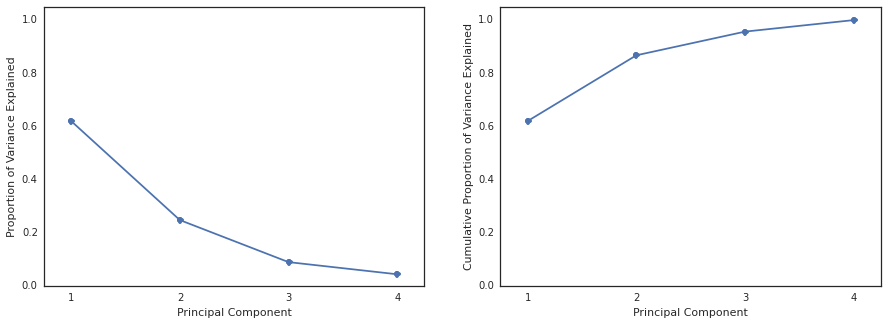

In [156]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot([1,2,3,4], pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')

ax2.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-o')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(0.75,4.25)
    ax.set_ylim(0,1.05)
    ax.set_xticks([1,2,3,4])

## Lab 2: Clustering

### § 10.5.1
###K-Means Clustering

In [2]:
np.random.seed(2)
X = np.random.standard_normal((50,2))
X[:25,0] = X[:25,0]+3
X[:25,1] = X[:25,1]-4

#### K = 2

In [3]:
km1 = KMeans(n_clusters=2, n_init=20)
km1.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [4]:
km1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1])

See plot for K=2 below.

####  K = 3

In [160]:
np.random.seed(4)
km2 = KMeans(n_clusters=3, n_init=20)
km2.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [161]:
pd.Series(km2.labels_).value_counts()

1    21
0    20
2     9
dtype: int64

In [162]:
km2.cluster_centers_

array([[-0.27876523,  0.51224152],
       [ 2.82805911, -4.11351797],
       [ 0.69945422, -2.14934345]])

In [163]:
km2.labels_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2])

In [164]:
km2.inertia_

68.973792009397215

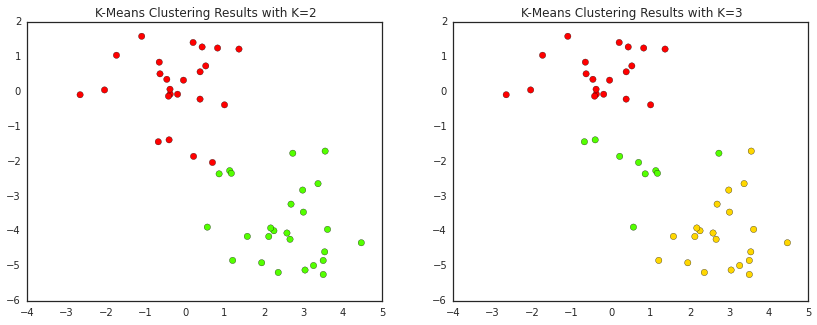

In [165]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')

### § 10.5.3
### Hierarchical Clustering

#### scipy

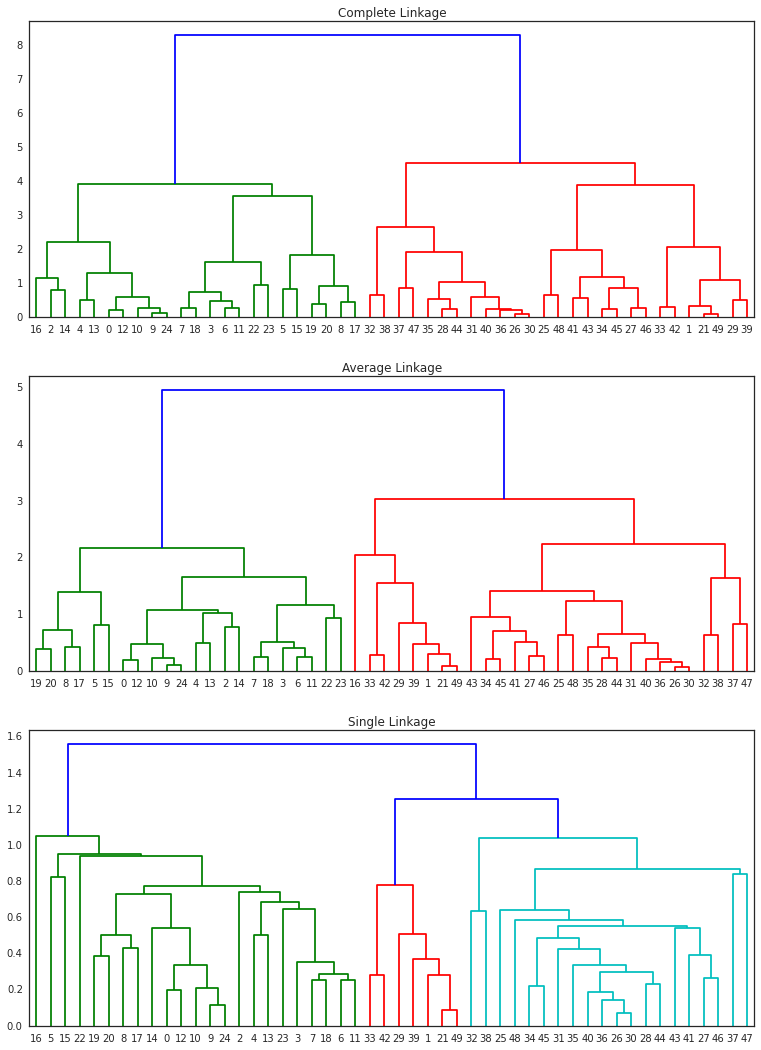

In [166]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(13,18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')

## Lab 3: NCI60 Data Example

### § 10.6.1 PCA

In [17]:
df2 = pd.read_csv('Data/NCI60_X.csv').drop('Unnamed: 0', axis=1)
df2.columns = np.arange(df2.columns.size)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Columns: 6830 entries, 0 to 6829
dtypes: float64(6830)
memory usage: 3.3 MB


In [108]:
y = pd.read_csv('Data/NCI60_y.csv', usecols=[1])
y.shape

(64, 1)

In [18]:
df2.iloc[:5,:5]

          0         1         2         3         4
0  0.300000  1.180000  0.550000  1.140000 -0.265000
1  0.679961  1.289961  0.169961  0.379961  0.464961
2  0.940000 -0.040000 -0.170000 -0.040000 -0.605000
3  0.280000 -0.310000  0.680000 -0.810000  0.625000
4  0.485000 -0.465000  0.395000  0.905000  0.200000

In [60]:
X = pd.DataFrame(scale(df2), index=y.x)
X.columns.name='Gene expressions'
X.index.name='Samples'
print(X.shape)
X.iloc[:5,:5]

(64, 6830)


Gene expressions         0         1         2         3         4
Samples                                                           
CNS               0.728671  1.607220  1.325688  1.355688 -0.604845
CNS               1.596418  1.753544  0.441686  0.654119  0.911898
CNS               2.190290 -0.016217 -0.349092  0.266465 -1.311310
RENAL             0.682995 -0.375502  1.628079 -0.444299  1.244434
BREAST            1.151170 -0.581759  0.965145  1.138767  0.361351

In [61]:
pca2 = PCA()
pca2.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [125]:
pca_loadings2 = pd.DataFrame(pca2.components_.T)
pca_loadings2.columns.name = 'Loading vectors'
pca_loadings2.index.name = 'Features'
print(pca_loadings2.shape)
pca_loadings2.iloc[:5,:5]

(6830, 64)


Loading vectors         0         1         2         3         4
Features                                                         
0               -0.010682  0.001324  0.008504 -0.003524 -0.010127
1               -0.002312  0.001675  0.010257  0.002604 -0.011401
2               -0.005880 -0.006289  0.010055 -0.010681  0.010265
3                0.003278  0.002666  0.008362 -0.007476  0.011248
4               -0.007678 -0.002508  0.013821  0.009509  0.004095

In [119]:
df2_plot = pd.concat([(X*pca_loadings2[0]).sum(axis=1),
                      (X*pca_loadings2[1]).sum(axis=1),
                      (X*pca_loadings2[2]).sum(axis=1),
                      (X*pca_loadings2[3]).sum(axis=1),
                      (X*pca_loadings2[4]).sum(axis=1)], axis=1, keys=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
df2_plot.head()

               PC1       PC2        PC3        PC4        PC5
Samples                                                      
CNS     -19.838042  3.555636  -9.812399   0.824246 -12.609984
CNS     -23.089215  6.441460 -13.478251  -5.635308  -8.035496
CNS     -27.456114  2.465143  -3.533054   1.341673 -12.564846
RENAL   -42.816801 -9.768358  -0.890073  -3.445043 -42.269904
BREAST  -55.418530 -5.198897 -21.094558 -15.849712 -10.443273

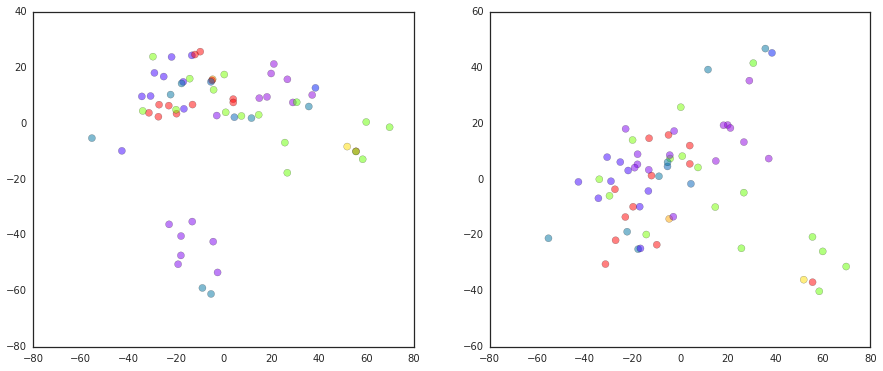

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.scatter(df2_plot.PC1, df2_plot.PC2, c=pd.factorize(df2_plot.index)[0], cmap=plt.cm.prism, alpha=0.5, s=50)
ax2.scatter(df2_plot.PC1, df2_plot.PC3, c=pd.factorize(df2_plot.index)[0], cmap=plt.cm.prism, alpha=0.5, s=50)

In [174]:
pd.DataFrame([df2_plot.std(axis=0, ddof=0).as_matrix(),
              pca2.explained_variance_ratio_[:5],
              np.cumsum(pca2.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=df2_plot.columns)

                              PC1        PC2        PC3        PC4        PC5
Standard Deviation      27.853469  21.481355  19.820465  17.032556  15.971807
Proportion of Variance   0.113589   0.067562   0.057518   0.042476   0.037350
Cumulative Proportion    0.113589   0.181151   0.238670   0.281145   0.318495

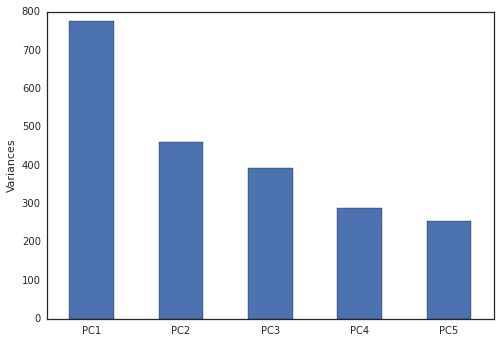

In [27]:
df2_plot.var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances')

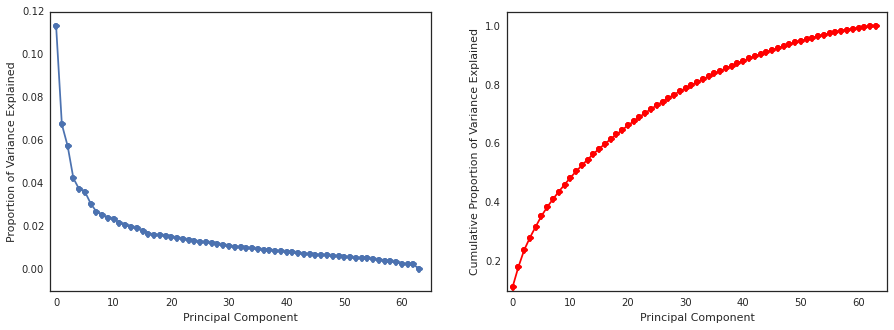

In [176]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(pca2.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

ax2.plot(np.cumsum(pca2.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)    

### § 10.6.2 Clustering

In [37]:
X= pd.DataFrame(scale(df2), index=y.x, columns=df2.columns)

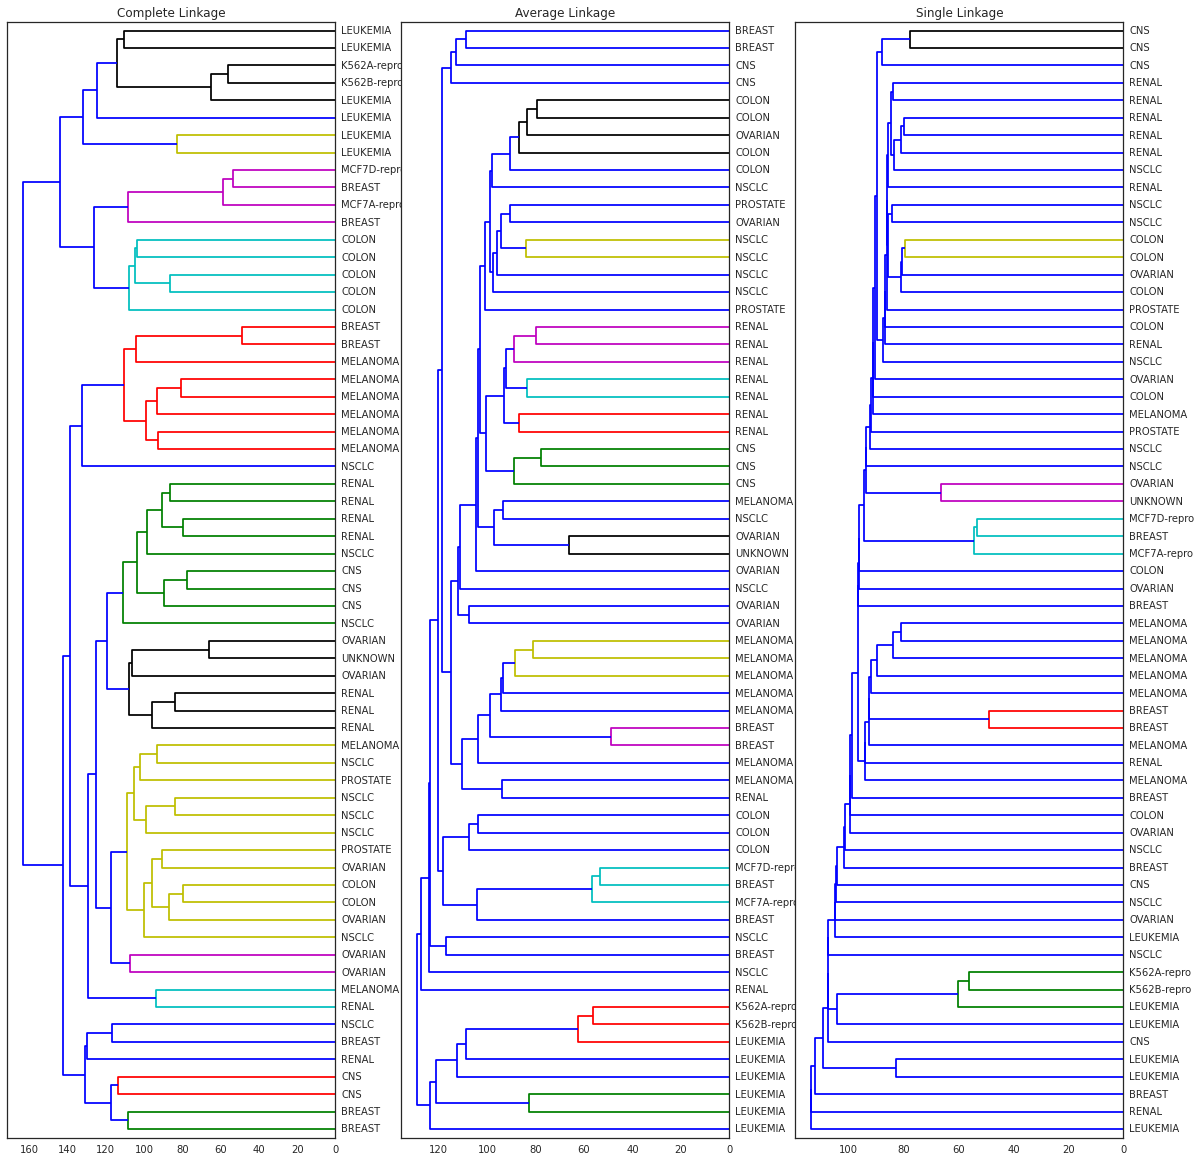

In [178]:
# Plotting the dendrograms with horizontal orientation because we cannot rotate the labels due to a bug.
# https://github.com/scipy/scipy/issues/3822

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=X.index, orientation='right',
                                   show_leaf_counts=True, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')

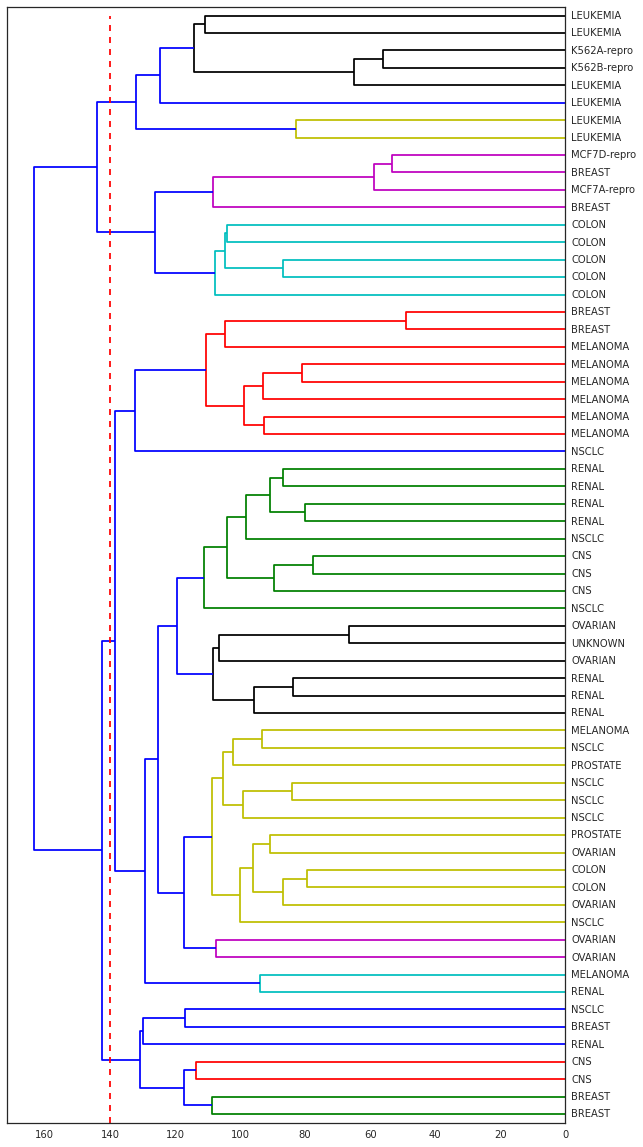

In [179]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X),
                            labels=X.index, show_leaf_counts=True, orientation='right')
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed')

##### KMeans

In [180]:
np.random.seed(2)
km4 = KMeans(n_clusters=4, n_init=50)
km4.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=50,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [181]:
km4.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [182]:
# Observations per KMeans cluster
pd.Series(km4.labels_).value_counts().sort_index()

0     8
1    23
2    24
3     9
dtype: int64

##### Hierarchical

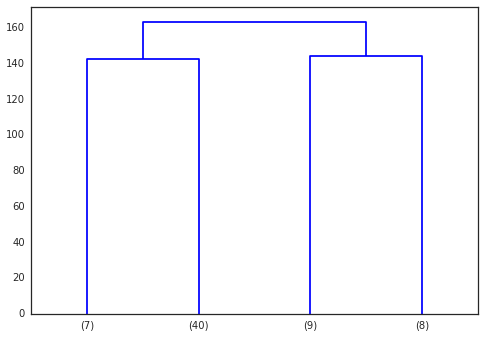

In [183]:
# Observations per Hierarchical cluster
cut4b = hierarchy.dendrogram(hierarchy.complete(X), truncate_mode='lastp', p=4,
                             show_leaf_counts=True)

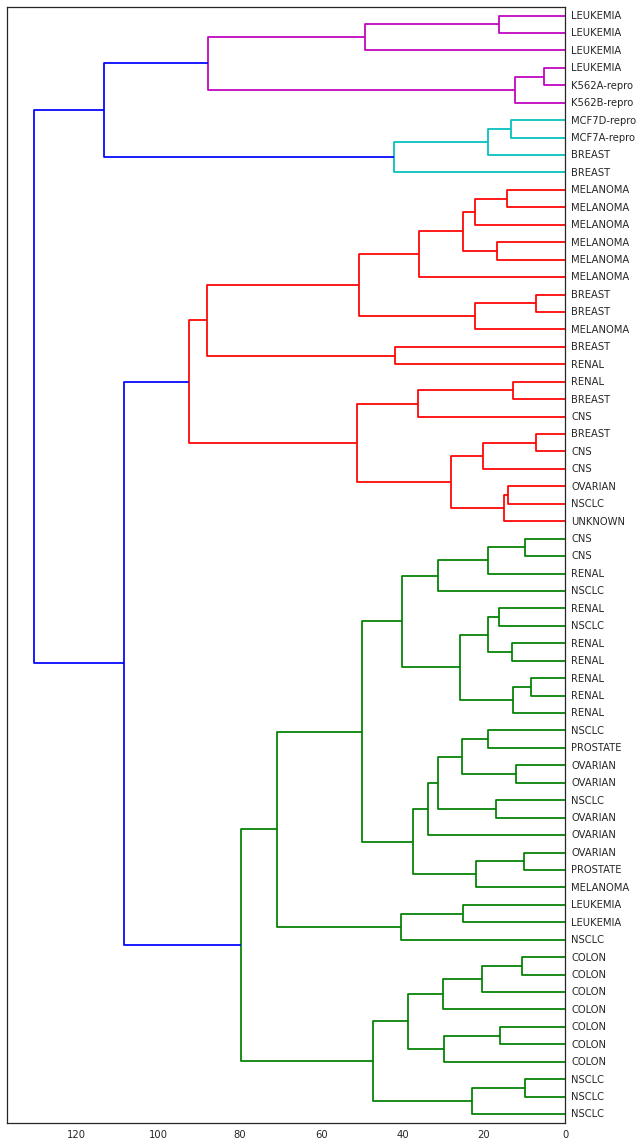

In [207]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(10,20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(df2_plot), labels=y.x.values, orientation='right', color_threshold=100)

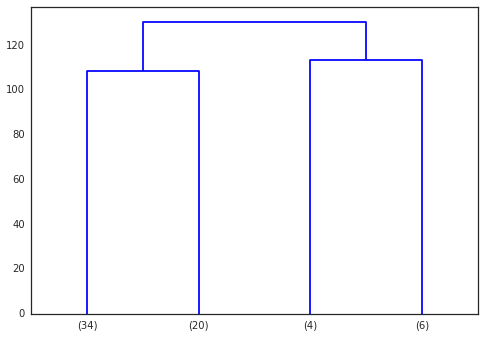

In [198]:
cut4c = hierarchy.dendrogram(hierarchy.complete(df2_plot), truncate_mode='lastp', p=4,
                             show_leaf_counts=True)
# See also color coding in plot above.